Imports are held here:

In [1]:
#basic data analysis
import numpy as np
import pandas as pd

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#other
import scipy.stats as stats

#datat preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#model
from sklearn.tree import DecisionTreeClassifier

#evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score #might not need confusion matrix

# Initial Look

Now let's import and take a look at the data:

In [2]:
#import the dataset
student_health = pd.read_csv('student_health_data.csv')

In [3]:
#look at first few instances
student_health.head()

,Student_ID,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours,Health_Risk_Level
0,1,24,M,50.663217,122.173015,84.419860,3.137350,9.028669,High,Moderate,Happy,34.520973,16.800956,Moderate
1,2,21,F,57.926042,110.778407,75.696145,3.699078,5.819697,Moderate,Good,Stressed,16.763846,15.791154,Moderate
2,3,22,M,59.294219,109.375673,83.803814,6.785156,5.892360,Low,Moderate,Happy,44.203798,25.678437,Moderate
3,4,24,M,76.826232,125.142227,78.091587,6.408509,6.884001,High,Poor,Happy,21.776645,20.808391,High
4,5,20,M,68.342769,107.515592,80.674937,7.264719,4.483450,Moderate,Poor,Happy,8.964999,15.194045,Moderate


From looking at the first few instances, I can see that some variables are continuous and some are categorical. It also looks like Student_ID could be removed.

In [4]:
#check for missing values
print(student_health.isna().sum())

#check for duplicates
print(student_health.duplicated().sum())

Student_ID                  0
Age                         0
Gender                      0
Heart_Rate                  0
Blood_Pressure_Systolic     0
Blood_Pressure_Diastolic    0
Stress_Level_Biosensor      0
Stress_Level_Self_Report    0
Physical_Activity           0
Sleep_Quality               0
Mood                        0
Study_Hours                 0
Project_Hours               0
Health_Risk_Level           0
dtype: int64
0


No missing values and, as expected, no duplicates. Let's go ahead and remove Student_ID

In [5]:
student_health = student_health.drop(columns=["Student_ID"])

In [6]:
student_health.head()

,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours,Health_Risk_Level
0,24,M,50.663217,122.173015,84.419860,3.137350,9.028669,High,Moderate,Happy,34.520973,16.800956,Moderate
1,21,F,57.926042,110.778407,75.696145,3.699078,5.819697,Moderate,Good,Stressed,16.763846,15.791154,Moderate
2,22,M,59.294219,109.375673,83.803814,6.785156,5.892360,Low,Moderate,Happy,44.203798,25.678437,Moderate
3,24,M,76.826232,125.142227,78.091587,6.408509,6.884001,High,Poor,Happy,21.776645,20.808391,High
4,20,M,68.342769,107.515592,80.674937,7.264719,4.483450,Moderate,Poor,Happy,8.964999,15.194045,Moderate


In [7]:
#look at shape/dimension of dataset
print(student_health.shape)
#look at data types for each column
print(student_health.dtypes)

(1000, 13)
Age                           int64
Gender                       object
Heart_Rate                  float64
Blood_Pressure_Systolic     float64
Blood_Pressure_Diastolic    float64
Stress_Level_Biosensor      float64
Stress_Level_Self_Report    float64
Physical_Activity            object
Sleep_Quality                object
Mood                         object
Study_Hours                 float64
Project_Hours               float64
Health_Risk_Level            object
dtype: object


The dataset consists of numerical variables (integer and float) and object variables. Looking through, these object variables are really just categorical variables. So let's change the datatype from object to categorical.

In [8]:
#convert object variables to categorical variables
for col in student_health.select_dtypes(include = ['object']).columns:
    student_health[col] = student_health[col].astype('category')

#check data types
print(student_health.dtypes)

Age                            int64
Gender                      category
Heart_Rate                   float64
Blood_Pressure_Systolic      float64
Blood_Pressure_Diastolic     float64
Stress_Level_Biosensor       float64
Stress_Level_Self_Report     float64
Physical_Activity           category
Sleep_Quality               category
Mood                        category
Study_Hours                  float64
Project_Hours                float64
Health_Risk_Level           category
dtype: object


Now all objects are set as category. This will help with analyzing the data before modeling.

# Outlier Detection 

The next step is to look at the numerical variables in more detail. Let's see if we can detect outliers.

In [9]:
#basic stats for numerical columns
student_health.describe()

,Age,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.9600,70.101863,119.835380,79.854756,5.483909,5.361601,30.227037,14.887368
std,2.0036,9.544663,14.604307,9.641699,2.596108,2.550382,10.341060,4.888624
min,18.0000,50.000000,90.000000,60.000000,1.008491,1.002186,5.000000,0.000000
25%,19.0000,63.347970,109.386868,73.115420,3.270567,3.172409,23.262704,11.573503
50%,21.0000,70.330916,120.051654,79.651738,5.368891,5.234889,30.432767,14.765873
75%,23.0000,76.425149,130.397799,86.535640,7.674233,7.471178,37.245193,18.159167
max,24.0000,99.650104,165.929204,107.659796,9.994153,9.964115,60.000000,32.720325


Above we have descriptive stats. We can see that the variables are on different scales - something to address when preparing for modeling. It also looks like there may be some outliers. In specific, there's a pretty big jump from 75% to max in Heart_Rate, Blood_Pressure_Systolic, Blood_Pressure_Diastolic, Study_Hours, and Project_Hours. Futher analysis will be needed.

To analyze potential outliers further, let's utilize some visualizations:

In [10]:
#list of numerical variables
numerical_var = ['Age', 'Heart_Rate', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
                 'Stress_Level_Biosensor', 'Stress_Level_Self_Report', 'Study_Hours', 'Project_Hours']

In [11]:
#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in numerical_var:
    outliers = identify_outliers(student_health, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

#display the outliers
outliers_df

,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours,Health_Risk_Level
198,19,M,99.650104,152.812332,81.798311,7.665972,4.733622,Moderate,Moderate,Neutral,41.520387,15.860464,Moderate
275,21,M,99.377528,98.811964,74.927286,6.611548,3.888419,Moderate,Moderate,Neutral,34.248981,11.354818,Moderate
769,24,F,96.631824,142.695139,63.073184,3.940650,3.479020,Moderate,Moderate,Happy,46.343832,22.940870,Low
941,22,M,96.875344,111.297845,69.414963,1.630618,6.891591,Moderate,Moderate,Stressed,19.422965,17.330091,Moderate
979,24,F,97.308672,135.537379,78.658548,8.664233,1.260971,High,Good,Happy,26.187293,13.899089,Moderate
899,18,F,50.000000,165.929204,77.116078,3.314371,6.006128,Moderate,Moderate,Happy,35.739767,25.310256,Moderate
439,19,F,66.932196,135.787934,107.659796,9.342168,1.262536,Moderate,Moderate,Neutral,27.308644,12.084991,Moderate
63,18,M,74.805621,113.068560,73.850496,9.185936,5.587814,Moderate,Moderate,Happy,59.863294,20.754383,Moderate
443,24,F,55.928560,90.000000,64.111815,3.508249,8.802469,Moderate,Poor,Stressed,60.000000,8.509177,Moderate
837,24,M,70.058106,129.669424,82.116004,2.518745,8.253731,Low,Poor,Happy,58.916587,13.646866,Moderate


In [12]:
#look at shape/dimension of dataset
outliers_df.shape

(21, 13)

Here is what I see looking at the outliers:
- Heart_Rate has 5 outliers, each with high values. This also represents the first 5 instances in the outliers_df dataframe.
- Blood_Pressure_Systolic has 1 outlier, which is also the max value. This is the 6th instance.
- Blood_Pressure_Diastolic also has 1 outlier, which is also the max value. This is the 7th instance.
- Stress levels don't seem to hold any outliers.
- Study_Hours have 3 outliers, each with high values. This covers 8th - 10th instances
- Project_Hours have 11 outliers, with both high and low values. Some of these values don't quite make sense, indicating that maybe there was a data entry problem.

Aside from that, some of the features have high or low values shown in the table that we can note, but are within the IQR.

Only 21 instance were considered to have outliers. Realistically, we can remove these and still have plenty of data to work with since the original dataset contains 1000 instances. With that in mind, let's goahead and remove the instances with outliers.

In [13]:
#get outlier indices
outlier_indices = outliers_df.index

#drop rows in dataset with outlier indices
cleaned_df = student_health.drop(outlier_indices)

#look at dimension of dataset
print(cleaned_df.shape)

(979, 13)


In [14]:
#look at basic stats
cleaned_df.describe()

,Age,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,20.954035,69.979106,119.788093,79.890649,5.493225,5.356630,30.077246,14.885170
std,1.997169,9.367907,14.482425,9.615105,2.593141,2.552939,10.265443,4.660111
min,18.000000,50.000000,90.000000,60.000000,1.008491,1.002186,5.000000,1.729188
25%,19.000000,63.307344,109.383136,73.103106,3.294550,3.152128,23.172107,11.646913
50%,21.000000,70.304789,120.061395,79.726681,5.401436,5.232666,30.314270,14.768098
75%,23.000000,76.343322,130.365350,86.548586,7.674901,7.474922,37.189126,18.106878
max,24.000000,94.722795,160.739199,106.450368,9.994153,9.964115,57.136198,27.885272


Looks like we successfully removed all outliers!

### Numerical

We'll begin by looking at correlations between numerical variables.

In [15]:
#calculate Pearson Correlation Matrix
pearson_corr = cleaned_df[numerical_var].corr(method='pearson')
pearson_corr

,Age,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
Age,1.000000,0.014115,-0.008258,0.008855,0.043984,0.016734,-0.078618,-0.000572
Heart_Rate,0.014115,1.000000,0.002642,-0.021330,0.039858,-0.017568,0.041596,-0.000839
Blood_Pressure_Systolic,-0.008258,0.002642,1.000000,0.015759,-0.033959,-0.011818,-0.004928,-0.048204
Blood_Pressure_Diastolic,0.008855,-0.021330,0.015759,1.000000,-0.011212,-0.008532,0.001248,-0.012685
Stress_Level_Biosensor,0.043984,0.039858,-0.033959,-0.011212,1.000000,-0.016057,-0.028816,0.001118
Stress_Level_Self_Report,0.016734,-0.017568,-0.011818,-0.008532,-0.016057,1.000000,-0.010993,0.016558
Study_Hours,-0.078618,0.041596,-0.004928,0.001248,-0.028816,-0.010993,1.000000,-0.036473
Project_Hours,-0.000572,-0.000839,-0.048204,-0.012685,0.001118,0.016558,-0.036473,1.000000


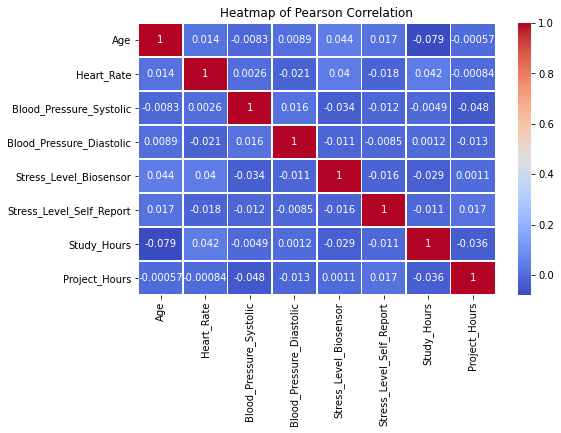

In [16]:
#heatmap of Pearson correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Pearson Correlation')
plt.show()

Looks like no numerical features are correlated. Let's verify this

In [17]:
#calculate Spearman's Rank Correlation Matric
spearman_corr = cleaned_df[numerical_var].corr(method='spearman')
spearman_corr

,Age,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Study_Hours,Project_Hours
Age,1.000000,0.010718,-0.004715,0.001238,0.044051,0.015880,-0.079549,0.004606
Heart_Rate,0.010718,1.000000,0.010531,-0.008705,0.052829,-0.022482,0.036688,0.000002
Blood_Pressure_Systolic,-0.004715,0.010531,1.000000,0.013235,-0.034453,-0.010599,-0.006829,-0.037278
Blood_Pressure_Diastolic,0.001238,-0.008705,0.013235,1.000000,-0.017856,-0.000378,0.001954,-0.022251
Stress_Level_Biosensor,0.044051,0.052829,-0.034453,-0.017856,1.000000,-0.016621,-0.031668,-0.001035
Stress_Level_Self_Report,0.015880,-0.022482,-0.010599,-0.000378,-0.016621,1.000000,-0.010669,0.013275
Study_Hours,-0.079549,0.036688,-0.006829,0.001954,-0.031668,-0.010669,1.000000,-0.039752
Project_Hours,0.004606,0.000002,-0.037278,-0.022251,-0.001035,0.013275,-0.039752,1.000000


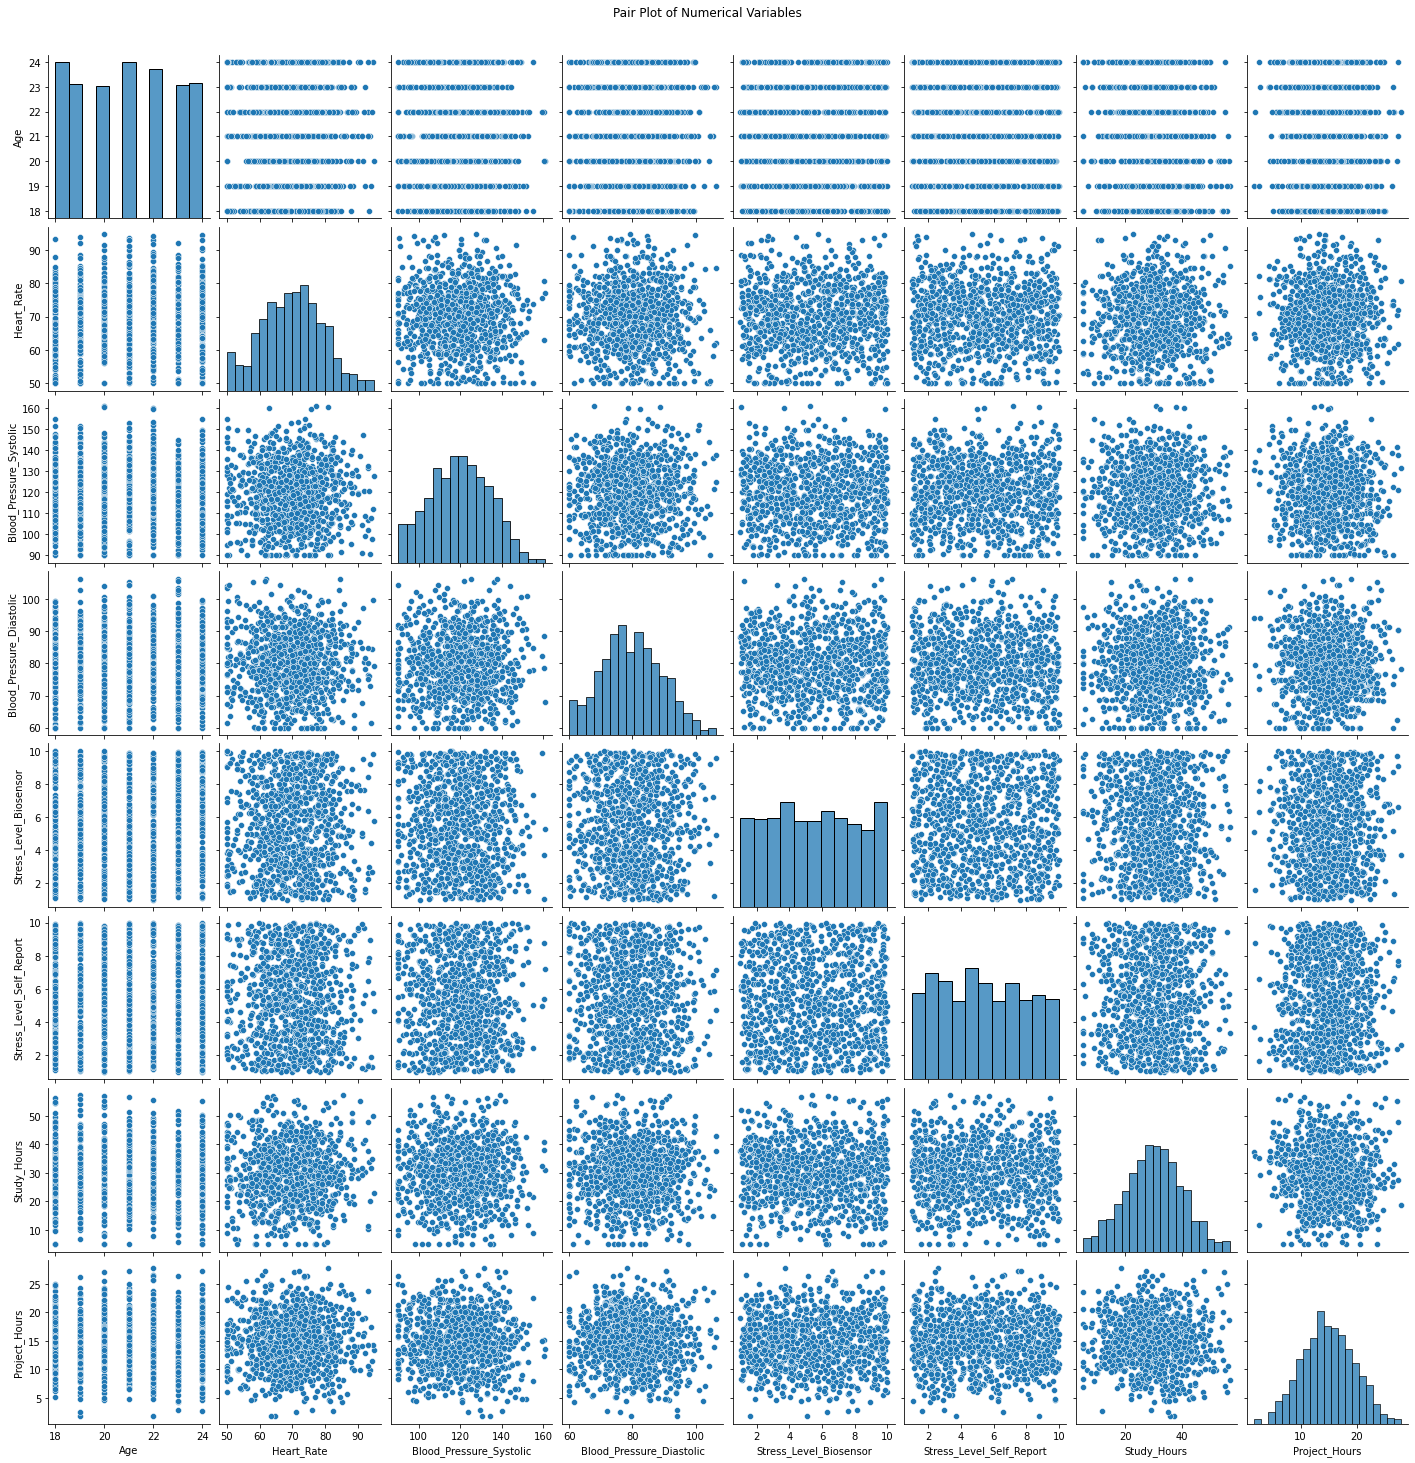

In [18]:
#pair plot
sns.pairplot(cleaned_df[numerical_var])
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()

Pair plots is a lot to look at. But by going over each of the scatterplots, I can verify that none of the numerical features are correlated. 

The last thing to check out now is to see how the numerical features correlate to the target variable. This could help in feature selection.

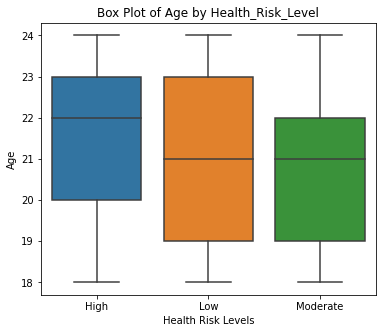

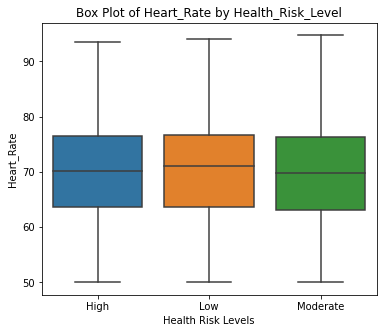

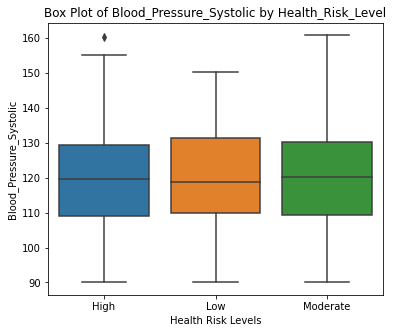

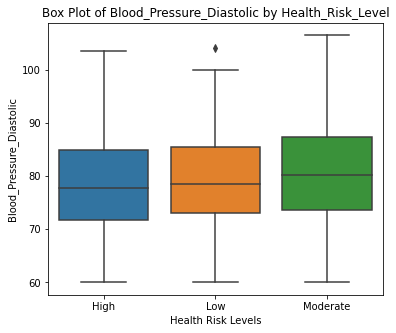

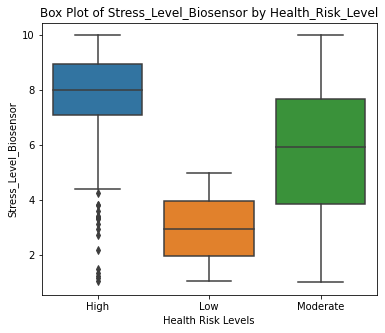

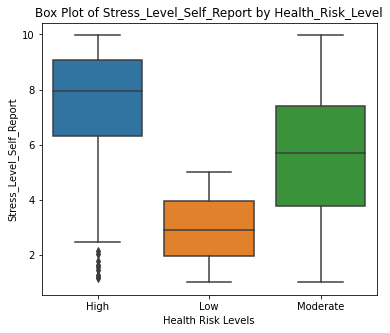

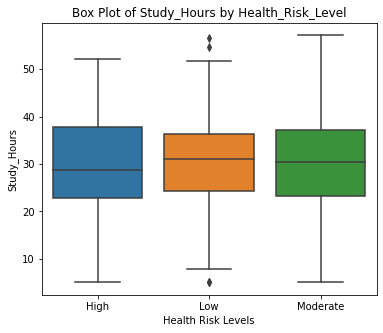

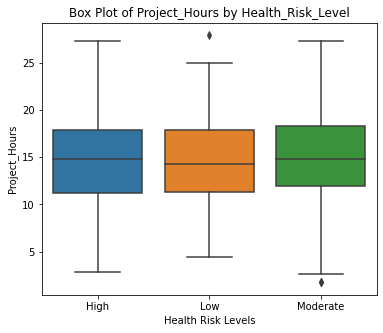

In [19]:
# Create Box Plots
for var in numerical_var:
    plt.figure(figsize=(6, 5))
    #create boxplot for each numerical variable grouped by the target variable
    sns.boxplot(x=cleaned_df['Health_Risk_Level'], y=cleaned_df[var])
    plt.title(f'Box Plot of {var} by Health_Risk_Level')
    plt.xlabel('Health Risk Levels')
    plt.ylabel(var)
    plt.show()

Here is what I've noted:
- The median Age is higher for "High" Health_Risk_Level than for the other levels. This indicates a potential correlation between Age and Health_Risk_Level.
    - Median Age is similar for Low and Medium levels.
- Median Heat_Rate is similar for all risk levels.
- Median Blood_Pressure_Systolic are similar, but there appears to be an outlier.
- Similar can be said about Blodd_Pressure_Diastolic.
- Median Stress_Level_Biosensor varies greatly between risk categories. Furthermore, there appears to be quite a bit of outliers in the high risk category.
- Similar can be said about Stress_Level_Selft_Report.
- Median Study_Hours are comparable, with some outliers in the low risk category.
- Similar can be said about Project_Hours, though there are outliers in the low and medium risk levels.

Overall, it looks like there are some instance of potential correlation with some of the features and the target variable, and there are instances of no potential correlation.

### Categorical

Now, let's look at the categorical variable in more detail.

In [20]:
#look at value counts for non-numerical columns

#create vector for non-numeric columns
obj_var = ['Gender', 'Physical_Activity', 'Sleep_Quality', 'Mood', 'Health_Risk_Level']

#iterate through each variable and print
for i in obj_var:
    print(cleaned_df[i].value_counts(), '\n')

M    506
F    473
Name: Gender, dtype: int64 

Moderate    475
Low         299
High        205
Name: Physical_Activity, dtype: int64 

Good        467
Moderate    308
Poor        204
Name: Sleep_Quality, dtype: int64 

Neutral     406
Happy       390
Stressed    183
Name: Mood, dtype: int64 

Moderate    656
Low         186
High        137
Name: Health_Risk_Level, dtype: int64 



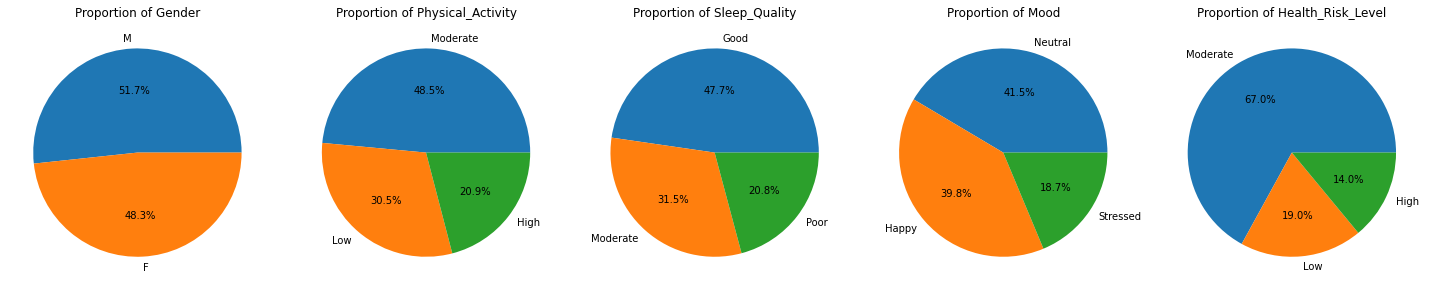

In [21]:
#pie chart

#create subplots: a grid of plots, one for each variable
fig, axes = plt.subplots(1, len(obj_var), figsize=(20, 5))

#loop through each variable in the list
for idx, var in enumerate(obj_var):
    cleaned_df[var].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[idx])
    axes[idx].set_title(f'Proportion of {var}')
    axes[idx].set_ylabel('')  #remove y-axis label for cleaner look

plt.tight_layout()
plt.show()

We can see that for all categorical features, the categories are imbalanced. Let's see how these categories relate to each other.

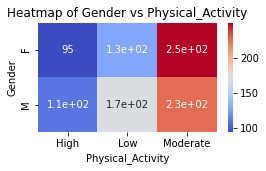

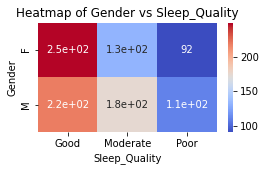

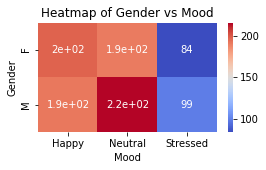

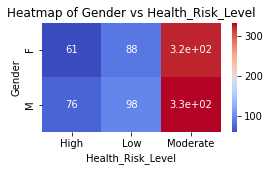

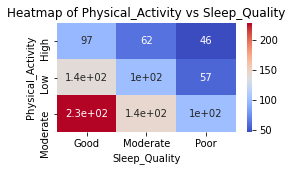

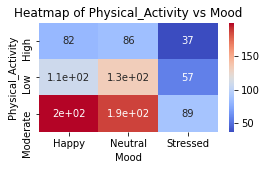

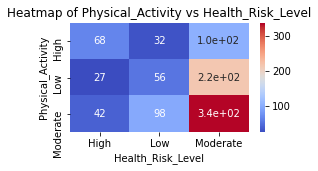

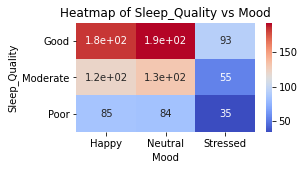

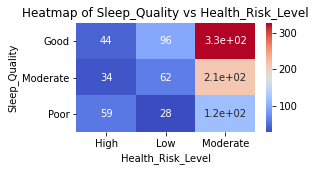

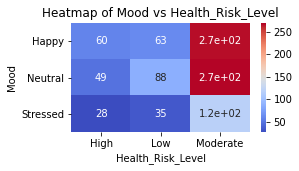

In [22]:
#Heatmap comparing each of the categorical variables to each other

#loop through each pair of variables without repeating
for i in range(len(obj_var)): #iterates over list of variables from beginning to end
    for j in range(i + 1, len(obj_var)): #ensure each pair is only visualized once
        var1 = obj_var[i]
        var2 = obj_var[j]
        
        #create a crosstab
        crosstab = pd.crosstab(cleaned_df[var1], cleaned_df[var2])
        
        #plot the heatmap
        plt.figure(figsize=(4, 2))
        sns.heatmap(crosstab, annot=True, cmap='coolwarm')
        plt.title(f'Heatmap of {var1} vs {var2}')
        plt.show()

Here is what I've noted:
- It seems like for each heatmap, we can see there is potential for some correlation.

In [23]:
#function to calculate Chi-Square p-value
def chi_square_test(x, y):
    #create contigency table from the two variables
    contingency_table = pd.crosstab(x, y)
    #perform Ch-Square Test for independence
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    #return p-value
    return p

#loop through unique pairs of variables
for i in range(len(obj_var)):
    for j in range(i + 1, len(obj_var)):
        #select the two variables for the current pair
        var1 = obj_var[i]
        var2 = obj_var[j]

        #calculate Chi-Square p-value
        p_value = chi_square_test(cleaned_df[var1], cleaned_df[var2])
        print(f'Chi-Square p-value for {var1} and {var2}: {p_value}')

Chi-Square p-value for Gender and Physical_Activity: 0.034586142078450614
Chi-Square p-value for Gender and Sleep_Quality: 0.015100291529196634
Chi-Square p-value for Gender and Mood: 0.44263321443120285
Chi-Square p-value for Gender and Health_Risk_Level: 0.5580824884585867
Chi-Square p-value for Physical_Activity and Sleep_Quality: 0.8204041135148793
Chi-Square p-value for Physical_Activity and Mood: 0.6261103118512352
Chi-Square p-value for Physical_Activity and Health_Risk_Level: 1.930445735375106e-16
Chi-Square p-value for Sleep_Quality and Mood: 0.8950487122842119
Chi-Square p-value for Sleep_Quality and Health_Risk_Level: 6.440596238339458e-10
Chi-Square p-value for Mood and Health_Risk_Level: 0.26315918913566794


Interpretation: if the p-value is < 0.05, it suggests there is a statistically significant association between the two variables. If > 0.05, it indicates that observed association is likely due to chance.

Keeping the interpretation in mind, we can see that, according to the Chi-Square test, there are associations between:
- Gender and Physical_Activity
- Gender and Slepp_Quality
- Physical_Activity and Health_Risk_Level
- Slepp_Quality and Health_Risk_Level

# Getting Ready to Model

#### Split the data

First we separate the our features and target. We'll make a feature matrix and a target vector.

In [24]:
#define feature matrix and target vector
X = cleaned_df.drop(columns = ["Health_Risk_Level"])
y = cleaned_df["Health_Risk_Level"]

In [25]:
#check sizes
print(f'cleaned_df size: {cleaned_df.shape}')
print(f'feature matrix size: {X.shape}')
print(f'target vector size: {y.shape}')

cleaned_df size: (979, 13)
feature matrix size: (979, 12)
target vector size: (979,)


In [26]:
X.head()

,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours
0,24,M,50.663217,122.173015,84.419860,3.137350,9.028669,High,Moderate,Happy,34.520973,16.800956
1,21,F,57.926042,110.778407,75.696145,3.699078,5.819697,Moderate,Good,Stressed,16.763846,15.791154
2,22,M,59.294219,109.375673,83.803814,6.785156,5.892360,Low,Moderate,Happy,44.203798,25.678437
3,24,M,76.826232,125.142227,78.091587,6.408509,6.884001,High,Poor,Happy,21.776645,20.808391
4,20,M,68.342769,107.515592,80.674937,7.264719,4.483450,Moderate,Poor,Happy,8.964999,15.194045


Next step is to split the data into a training set (80%), and validation set for hyperparameter tuning (10%) and a test set for a final model performance (10%)

In [27]:
#split data into a training set and a temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

#split the temp set into a validation set and final test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 12)

Now to ensure that that the split occurred as desired. First we check the sizes of our feature sets

In [28]:
#check number of instances in each split
print(f"Training set size: {X_train.shape[0]}") #X_train.shape[0] gives the number of rows in the trainin set
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 783
Validation set size: 98
Test set size: 98


In [29]:
print(783/979)
print(98/979)

0.7997957099080695
0.10010214504596528


Now to ensure that each target variable has the same distribution.

In [30]:
#print class distribution as percent
print("Class distribution in Training Set:") #training set
print(y_train.value_counts(normalize=True))  #normalized (percentages)

print("\nClass distribution in Validation Set:") #validation set
print(y_val.value_counts(normalize=True))

print("\nClass distribution in Test Set:") #test set
print(y_test.value_counts(normalize=True))

Class distribution in Training Set:
Moderate    0.670498
Low         0.190294
High        0.139208
Name: Health_Risk_Level, dtype: float64

Class distribution in Validation Set:
Moderate    0.663265
Low         0.193878
High        0.142857
Name: Health_Risk_Level, dtype: float64

Class distribution in Test Set:
Moderate    0.673469
Low         0.183673
High        0.142857
Name: Health_Risk_Level, dtype: float64


As we can see, the data has been successfully split!

#### Preprocess the data

Now that the data has been split, let's go ahead and preprocess it. We begin by encoding the categorical data.
- It should be noted that tree-based models don't require as much preprocessing, but to ensure consistency across different models (tree-based, KNN, SVM), it's simpler to preprocess the data once and use the preprocessed data for all models.
- LabelEncoder converts each category into a unique integer.
- pd.get_dummies is used for one-hot encoding
- Aligning ensures all datasets have the same features.

In [31]:
#encode categorical features - uses one-hot encoding
X_train_encode = pd.get_dummies(X_train)
X_val_encode = pd.get_dummies(X_val)
X_test_encode = pd.get_dummies(X_test)

#align validation and test sets with training set - ensures same columns
X_val_encode = X_val_encode.reindex(columns = X_train_encode.columns, fill_value = 0)
X_test_encode = X_test_encode.reindex(columns = X_train_encode.columns, fill_value = 0)

#initialize and fit scaler on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode)

#transform validation and test data
X_val_scaled = scaler.transform(X_val_encode)
X_test_scaled = scaler.transform(X_test_encode)

#manually set class order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Low", "Moderate", "High"])  #custom order

#encode labels
y_train_encode = label_encoder.transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

#rename matrices and vectors for ease of use
X_train2 = X_train_scaled
X_val2 = X_val_scaled
X_test2 = X_test_scaled

y_train2 = y_train_encode
y_val2 = y_val_encode
y_test2 = y_test_encode

In [32]:
#display mapping of original labels to encoded values
label_mapping = dict(enumerate(label_encoder.classes_))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {0: 'Low', 1: 'Moderate', 2: 'High'}


Now that we have our data preprocess, it's time to begin the modeling process.

# KNN Model Building

In [33]:
#libraries 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import RFE

## Initial KNN Model

In [34]:
# Initial KNN Model 
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train2, y_train2)
y_pred_knn = knn.predict(X_val2)
y_pred_knn

# Evaluate initial model
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.68
Weighted F1-Score: 0.68
Weighted Precision: 0.72
Weighted Recall: 0.68
Confusion Matrix:
Predicted   0   1  2
Actual              
0           8  11  0
1          12  53  0
2           2   6  6


**Initial Analysis:**
Initial Models prove to be moderately effective at classification with accuracy around 68%. We will fine tune this model in hopes of increasing these results and reducing error. 

### Parameter Exploration and Tuning

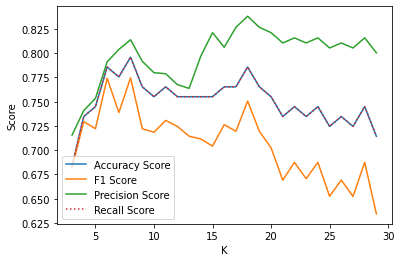

In [35]:
# Testing Number of Neighbors 

acc = {}
f1 = {}
prec = {}
recall = {}
k_levels = list(range(3, 30))

for k in k_levels:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train2, y_train2)
    y_pred = knn.predict(X_val2)
    acc[k] = accuracy_score(y_val2, y_pred)
    f1[k] = f1_score(y_val2, y_pred,  average='weighted')
    prec[k] = precision_score(y_val2, y_pred, average='weighted')
    recall[k] = recall_score(y_val2, y_pred, average='weighted')
    
ACC = list(acc.values())
F1 = list(f1.values())
PREC = list(prec.values())
RECALL = list(recall.values())

# Plotting K v/s accuracy graph
plt.plot(k_levels, ACC, label = 'Accuracy Score',)
plt.plot(k_levels, F1, label = 'F1 Score')
plt.plot(k_levels, PREC, label = 'Precision Score')
plt.plot(k_levels, RECALL, label = 'Recall Score',  linestyle='dotted')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.show()

**Initial Score Analysis**
Exploring the impact on the number of neighbors was the first step taken to fine tune the initial KNN model. This helps inform which values are best to be included in the gridsearch.It seems we will explore k values between 5 and 20 for the next step in our model tuning. This range of values seems to have the lower chance of overfitting than values outside of this range.  Something interesting happened in that our accuracy scores were identical to the recall scores. This shows that the weighting of the classes within the recall impacts the misclassification errors to be distributed evenly by the class frequency.

In [36]:
# Grid Search for Best Parameters
param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train2, y_train2)

# Print Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation Score: 0.7599297729870977


In [37]:
# Cross Validation with Best Parameters 
best_knn = grid_search.best_estimator_
best_knn.fit(X_train2, y_train2)
cv_scores = cross_val_score(best_knn, X_train2, y_train2, cv=5)

print("Cross-validation scores:", cv_scores)
print(f'Mean CV score: {np.mean(cv_scores):.3f}')

Cross-validation scores: [0.73248408 0.77707006 0.74522293 0.75641026 0.78846154]
Mean CV score: 0.760


### Testing Best Model

In [38]:
# Validation Set 

y_pred_knn = best_knn.predict(X_val2)
y_pred_knn

# Evaluate best model on validation set 
knn_acc_val = accuracy_score(y_val2, y_pred_knn)
knn_f1_val = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision_val = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall_val = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab_val = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc_val:.2f}')
print(f'Weighted F1-Score: {knn_f1_val:.2f}')
print(f'Weighted Precision: {knn_precision_val:.2f}')
print(f'Weighted Recall: {knn_recall_val:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab_val)

Validation Accuracy: 0.76
Weighted F1-Score: 0.72
Weighted Precision: 0.77
Weighted Recall: 0.76
Confusion Matrix:
Predicted  0   1  2
Actual             
0          6  13  0
1          3  62  0
2          0   8  6


In [39]:
# Test Set 
y_pred_knn = best_knn.predict(X_test2)
y_pred_knn

# Evaluate best model on test set 
knn_acc_test = accuracy_score(y_test2, y_pred_knn)
knn_f1_test = f1_score(y_test2, y_pred_knn, average='weighted')
knn_precision_test = precision_score(y_test2, y_pred_knn, average='weighted')
knn_recall_test = recall_score(y_test2, y_pred_knn, average='weighted')
confusion_crosstab_test = pd.crosstab(y_test2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Test Accuracy: {knn_acc_test:.2f}')
print(f'Weighted F1-Score: {knn_f1_test:.2f}')
print(f'Weighted Precision: {knn_precision_test:.2f}')
print(f'Weighted Recall: {knn_recall_test:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab_test)

Test Accuracy: 0.74
Weighted F1-Score: 0.70
Weighted Precision: 0.76
Weighted Recall: 0.74
Confusion Matrix:
Predicted  0   1  2
Actual             
0          4  14  0
1          2  64  0
2          0   9  5


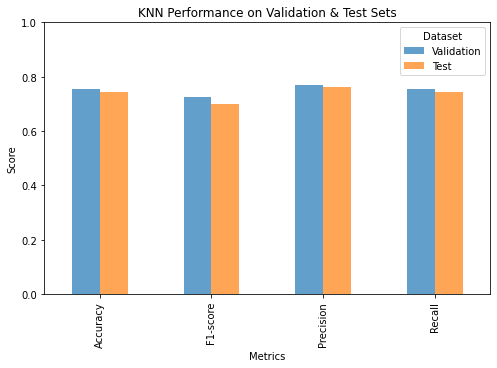

In [40]:
# Bar graph of scores 

knn_scores = pd.DataFrame()
knn_scores['Validation'] = [knn_acc_val, knn_f1_val, knn_precision_val, knn_recall_val]
knn_scores['Test'] = [knn_acc_test, knn_f1_test, knn_precision_test, knn_recall_test]


# Plot the DataFrame as a bar chart
knn_scores.plot(kind='bar', figsize=(8, 5), alpha=0.7)

# Formatting
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('KNN Performance on Validation & Test Sets')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Accuracy', 'F1-score', 'Precision', 'Recall'])
plt.ylim(0, 1) 
plt.legend(title='Dataset')

# Show the plot
plt.show()

When comparing the validation and test set accuracies, we do not see much drastic changes and therefore this means our model is not overfitting too much to the training set and is performing well on both the held out sets. 

## Feature Importance 

In [41]:
# Determine Feature Importance

perm_importance = permutation_importance(best_knn, X_train2, y_train2, scoring='accuracy')

feature_importances = perm_importance.importances_mean
features = X_train_encode.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nPermutation Feature Importance:\n", importance_df)


Permutation Feature Importance:
                        Feature  Importance
5     Stress_Level_Self_Report    0.065900
4       Stress_Level_Biosensor    0.059770
10      Physical_Activity_High    0.034227
15          Sleep_Quality_Poor    0.022989
13          Sleep_Quality_Good    0.014304
3     Blood_Pressure_Diastolic    0.009195
11       Physical_Activity_Low    0.007918
14      Sleep_Quality_Moderate    0.004342
12  Physical_Activity_Moderate    0.004087
1                   Heart_Rate    0.002299
0                          Age   -0.000511
18               Mood_Stressed   -0.001022
17                Mood_Neutral   -0.001277
8                     Gender_F   -0.002554
2      Blood_Pressure_Systolic   -0.002554
9                     Gender_M   -0.002554
7                Project_Hours   -0.004342
6                  Study_Hours   -0.005109
16                  Mood_Happy   -0.012516


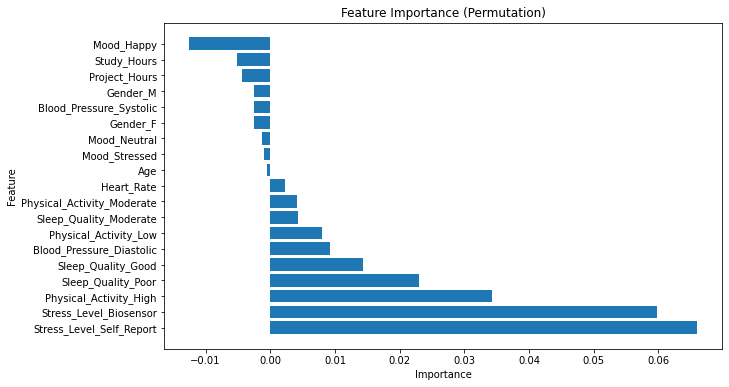

In [42]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Analysis:

Permutation Importance method assesses the impact on accuracy score when this variable is removed during a particular permutation.

Most impacful features: Stress_Level_Biosensor, Stress_Level_Self_Report, Physical_Activity_High, Sleep_Quality_Poor. These are the same important features as those found through the Trees exploration. 

## Rerun KNN With Top 4 Features 

In [43]:
important_features = ['Stress_Level_Self_Report', 'Stress_Level_Biosensor', 'Sleep_Quality_Poor', 'Physical_Activity_High']

#create subsets
X_train_subset = X_train_encode[important_features]
X_val_subset = X_val_encode[important_features]
X_test_subset = X_test_encode[important_features]

#scale subsets - note we created subset from the encoded, so scaling still needs to be done.
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_val_subset_scaled = scaler.transform(X_val_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

#check the shapes
print(X_train_subset_scaled.shape, X_val_subset_scaled.shape, X_test_subset_scaled.shape)

#rename for ease of use
X_train3 = X_train_subset_scaled
X_val3 = X_val_subset_scaled
X_test3 = X_test_subset_scaled

(783, 4) (98, 4) (98, 4)


### Initial Model On Top 4 Features

In [44]:
# Initial KNN Model 
pruned_knn = KNeighborsClassifier(n_neighbors = 3)
pruned_knn.fit(X_train3, y_train2)
y_pred_knn = pruned_knn.predict(X_val3)
y_pred_knn

# Evaluate initial model
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.93
Weighted F1-Score: 0.93
Weighted Precision: 0.93
Weighted Recall: 0.93
Confusion Matrix:
Predicted   0   1   2
Actual               
0          17   2   0
1           0  62   3
2           0   2  12


### Parameter Tuning On Top 4 Features

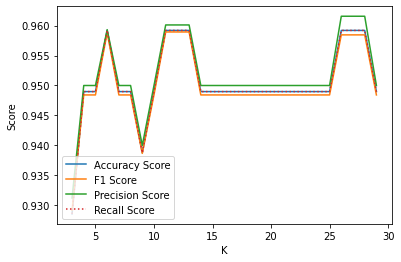

In [45]:
# Testing Number of Neighbors 

acc = {}
f1 = {}
prec = {}
recall = {}
k_levels = list(range(3, 30))

for k in k_levels:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train3, y_train2)
    y_pred = knn.predict(X_val3)
    acc[k] = accuracy_score(y_val2, y_pred)
    f1[k] = f1_score(y_val2, y_pred,  average='weighted')
    prec[k] = precision_score(y_val2, y_pred, average='weighted')
    recall[k] = recall_score(y_val2, y_pred, average='weighted')
    
ACC = list(acc.values())
F1 = list(f1.values())
PREC = list(prec.values())
RECALL = list(recall.values())

# Plotting K v/s accuracy graph
plt.plot(k_levels, ACC, label = 'Accuracy Score',)
plt.plot(k_levels, F1, label = 'F1 Score')
plt.plot(k_levels, PREC, label = 'Precision Score')
plt.plot(k_levels, RECALL, label = 'Recall Score',  linestyle='dotted')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.show()

In [46]:
# Grid Search for Best Parameters
param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train3, y_train2)

# Print Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Score: 0.9667646578474605


In [47]:
# Cross Validation with Best Parameters 
best_knn = grid_search.best_estimator_
best_knn.fit(X_train3, y_train2)
cv_scores = cross_val_score(best_knn, X_train3, y_train2, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

Cross-validation scores: [0.98089172 0.95541401 0.98726115 0.94871795 0.96153846]
Mean CV score: 0.9667646578474605


### Testing Top 4 Features Model

In [48]:
# Validation Set 

y_pred_knn = best_knn.predict(X_val3)
y_pred_knn

# Evaluate best model on validation set 
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.95
Weighted F1-Score: 0.95
Weighted Precision: 0.95
Weighted Recall: 0.95
Confusion Matrix:
Predicted   0   1   2
Actual               
0          17   2   0
1           0  64   1
2           0   2  12


In [49]:
# Test Set 
y_pred_knn = best_knn.predict(X_test3)
y_pred_knn

# Evaluate best model on test set 
knn_acc = accuracy_score(y_test2, y_pred_knn)
knn_f1 = f1_score(y_test2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_test2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_test2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Test Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Test Accuracy: 0.96
Weighted F1-Score: 0.96
Weighted Precision: 0.96
Weighted Recall: 0.96
Confusion Matrix:
Predicted   0   1   2
Actual               
0          16   2   0
1           1  65   0
2           0   1  13


**Prune Model Accuracy:**

When focusing strictly on the top 4 impactful features of the dataset, we are able to increase our accuracy from values in the 70s to values  closer to 0.95 and 0.96. This is an impressive increase and the test on both the validation and test sets indicates that we likely aren't seeing a singularly remarkable increase, but a generalizable model to multiple test sets. 

### Feature Importance of Top 4 Features

In [50]:
# Determine Feature Importance

perm_importance = permutation_importance(best_knn, X_train3, y_train2, scoring='accuracy')

feature_importances = perm_importance.importances_mean
features = X_train_subset.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nPermutation Feature Importance:\n", importance_df)


Permutation Feature Importance:
                     Feature  Importance
0  Stress_Level_Self_Report    0.360664
1    Stress_Level_Biosensor    0.354023
3    Physical_Activity_High    0.069987
2        Sleep_Quality_Poor    0.060792


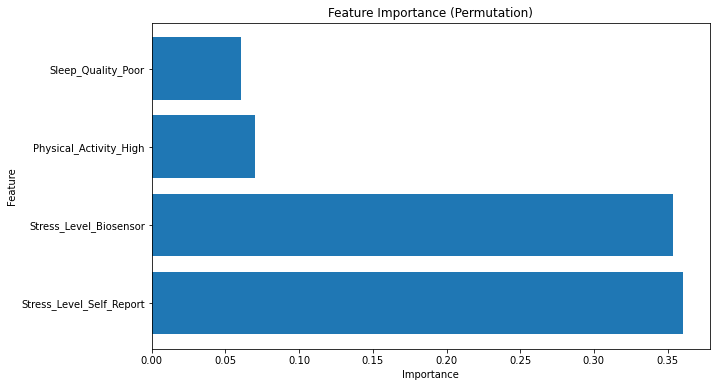

In [51]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Removing other features also increased the importance impact of these features. This makes sense and seems somewhat proportional to the size of impact these features had when amongst the other variables with the Stress_Level_Biosensor and Stress_Level_Self_Report having the greatest impact and the attributes of High Physical Actviity and Poor Sleep Quality having much less but still some impact on the accurcacy metrics. 

Future Notes:
Education around Stress Reduction techniques,
High Physical Activity has greater impact on the score than Low or Moderate Physical Activity. 
Poor Sleep Quality has great impact on the score than Good or Great Sleep Quality. 